In [4]:
!pip install beautifulsoup4
!pip install lxml
###import library that handles requests
import requests
###import library for data analsysis
import pandas as pd
###import library to handle data in a vectorized manner
import numpy as np
###import library for random number generation
import random

!conda install -c conda-forge geopy --yes
###module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

###libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

from IPython.display import display_html
import pandas as pd
import numpy as np
    
###tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
###import plotting library
import folium
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 122kB 18.2MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 3.2MB/s eta 0:00:01     |████████████████████████████████| 5.5MB 3.2MB/s 
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         395 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/

In [6]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')

###extract table
Neighbs_table = soup.find('table', class_='wikitable sortable')

In [7]:

# Now, let's create our Panda DataFrame
# I use first a list that I populate with the data from the table Neighbs_table
Nb_table = []
for tr in Neighbs_table.find_all('tr'):
    td = tr.find_all('td')
    row = [tr.text.replace("\n","") for tr in td] # Removing the "\n" if exists
    Nb_table.append(row)
df_Toronto = pd.DataFrame(Nb_table, columns= ['Postalcode','Borough','Neighborhood'])

# Now I drop any empty NA rows from the DataFrame
df_Toronto = df_Toronto.dropna()

# It was requested to "Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned."
df_Toronto = df_Toronto[df_Toronto.Borough != 'Not assigned']

# Request: More than one neighborhood can exist in one postal code area. For example, 
# in the table on the Wikipedia page, you will notice that M5A is listed twice 
# and has two neighborhoods: Harbourfront and Regent Park. These two rows will 
# be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
df_Toronto = df_Toronto.groupby(['Postalcode','Borough'], sort=False).agg( ', '.join).reset_index()

# Now Replacing all the 'Not assigned' Neighborhood by the value of Borough
# Example :  for M9A PostalCode in the table on the Wikipedia page, 
# the value of the Borough and the Neighborhood columns will be Queen's Park.
df_Toronto.loc[df_Toronto['Neighborhood']=='Not assigned', 'Neighborhood' ]= df_Toronto['Borough']

# Now removing any duplicates rows
df_Toronto.drop_duplicates(inplace=True)

df_Toronto

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [8]:
df_Toronto.shape

(103, 3)

In [9]:
# I will use the csv file from http://cocl.us/Geospatial_data 
# Read the csv file, put it in a DataFrame
# Then merge both DataFrames

df_Toronto_Geocode=pd.read_csv('http://cocl.us/Geospatial_data')

df_Toronto_Geocode.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
# The data obtained from the CSV has 3 columns. But before merging, we need to rename
# 'Postal Code' column to 'Postalcode'
df_Toronto_Geocode.rename(columns={'Postal Code':'Postalcode'},inplace=True)

# Now merging both DataFrames
df_Toronto_Geodata = pd.merge(df_Toronto_Geocode, df_Toronto, on='Postalcode')
df_Toronto_Geodata.head()

,Postalcode,Latitude,Longitude,Borough,Neighborhood
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


In [12]:
# The DataFrames are merged, but now, I need to move columns 'Latitude' and 'Longitude' to the end of the DF.
df_Toronto_Geodata= df_Toronto_Geodata.reindex(columns=['Postalcode','Borough','Neighborhood','Latitude','Longitude'])
df_Toronto_Geodata

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


In [13]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [14]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_Toronto_Geodata['Borough'].unique()),
        df_Toronto_Geodata.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [15]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [16]:
# create map of Toronto using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_Toronto_Geodata['Latitude'], df_Toronto_Geodata['Longitude'], df_Toronto_Geodata['Borough'], df_Toronto_Geodata['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [25]:
CLIENT_ID = 'KEKNS5VT02SJHBU2THKIYDYWL1ETD1NQG5PXCVUET5MTB4IG' # your Foursquare ID
CLIENT_SECRET = 'MMLUY4M14OGPBGHFFPPSMAPMMSJ1Y2T1GBVXPJTAFCOMFE1K' # your Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KEKNS5VT02SJHBU2THKIYDYWL1ETD1NQG5PXCVUET5MTB4IG
CLIENT_SECRET:MMLUY4M14OGPBGHFFPPSMAPMMSJ1Y2T1GBVXPJTAFCOMFE1K


In [26]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=KEKNS5VT02SJHBU2THKIYDYWL1ETD1NQG5PXCVUET5MTB4IG&client_secret=MMLUY4M14OGPBGHFFPPSMAPMMSJ1Y2T1GBVXPJTAFCOMFE1K&v=20180604&ll=43.6534817,-79.3839347&radius=1000&limit=100'

In [27]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5edd6baab9a389001be29648'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 240,
  'suggestedBounds': {'ne': {'lat': 43.66248170900001,
    'lng': -79.37151886118865},
   'sw': {'lat': 43.64448169099999, 'lng': -79.39635053881135}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
  

In [28]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [29]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Indigo,Bookstore,43.653515,-79.380696
3,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684
4,Textile Museum of Canada,Art Museum,43.654396,-79.386500


In [30]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
toronto_venues = getNearbyVenues(names=df_Toronto_Geodata['Neighborhood'],
                                   latitudes=df_Toronto_Geodata['Latitude'],
                                   longitudes=df_Toronto_Geodata['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

KeyError: 'groups'

In [33]:
print(toronto_venues.shape)
toronto_venues.head()

(6882, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant
1,"Malvern, Rouge",43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
2,"Malvern, Rouge",43.806686,-79.194353,RBC Royal Bank,43.798782,-79.197090,Bank
3,"Malvern, Rouge",43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
4,"Malvern, Rouge",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant


In [34]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,61,61,61,61,61,61
"Alderwood, Long Branch",47,47,47,47,47,47
"Bathurst Manor, Wilson Heights, Downsview North",41,41,41,41,41,41
Bayview Village,14,14,14,14,14,14
"Bedford Park, Lawrence Manor East",74,74,74,74,74,74
Berczy Park,100,100,100,100,100,100
"Birch Cliff, Cliffside West",10,10,10,10,10,10
"Brockton, Parkdale Village, Exhibition Place",100,100,100,100,100,100
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100


In [35]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 343 uniques categories.


In [37]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(6882, 343)


,Zoo Exhibit,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Nudist Beach,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,

In [38]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Non-Profit,Noodle House,Nudist Beach,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,

In [39]:
toronto_grouped.shape

(99, 343)

In [41]:
num_top_venues = 6

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                  venue  freq
0    Chinese Restaurant  0.18
1           Coffee Shop  0.07
2      Asian Restaurant  0.05
3        Breakfast Spot  0.03
4  Gym / Fitness Center  0.03
5                Bakery  0.03


----Alderwood, Long Branch----
              venue  freq
0              Park  0.06
1      Burger Joint  0.04
2     Grocery Store  0.04
3  Toy / Game Store  0.04
4       Pizza Place  0.04
5       Coffee Shop  0.04


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0         Park  0.12
1  Coffee Shop  0.07
2  Pizza Place  0.07
3         Bank  0.05
4  Gas Station  0.05
5          Gym  0.02


----Bayview Village----
          venue  freq
0          Bank  0.14
1         Trail  0.14
2   Gas Station  0.14
3          Park  0.14
4    Restaurant  0.07
5  Skating Rink  0.07


----Bedford Park, Lawrence Manor East----
                venue  freq
0         Coffee Shop  0.08
1  Italian Restaurant  0.08
2    Sushi Restaurant  0.08
3              B

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Chinese Restaurant,Coffee Shop,Asian Restaurant,Shopping Mall,Hong Kong Restaurant
1,"Alderwood, Long Branch",Park,Burger Joint,Grocery Store,Toy / Game Store,Café
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Pizza Place,Coffee Shop,Bank,Gas Station
3,Bayview Village,Bank,Park,Trail,Gas Station,Grocery Store
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sushi Restaurant,Bakery,Bagel Shop


In [46]:
toronto_PizzaPlace = toronto_grouped[["Neighborhood","Pizza Place"]]
toronto_PizzaPlace.head(10)

,Neighborhood,Pizza Place
0,Agincourt,0.016393
1,"Alderwood, Long Branch",0.042553
2,"Bathurst Manor, Wilson Heights, Downsview North",0.073171
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.027027
5,Berczy Park,0.010000
6,"Birch Cliff, Cliffside West",0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.010000
8,"Business reply mail Processing Centre, South C...",0.030000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.028986


In [47]:
toronto_PizzaPlace.max()

Neighborhood    York Mills, Silver Hills
Pizza Place                     0.114286
dtype: object

In [48]:
# Now let's merge the Toronto Geodat and the Toronto Pizza Places data per Neighborhood
toronto_PizzaPlace_merged = pd.merge(df_Toronto_Geodata, toronto_PizzaPlace, on='Neighborhood')

# Now, let's change the columns order
toronto_PizzaPlace_merged = toronto_PizzaPlace_merged.reindex(columns=['Postalcode','Borough','Neighborhood','Pizza Place','Latitude','Longitude'])

toronto_PizzaPlace_merged.head()

,Postalcode,Borough,Neighborhood,Pizza Place,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",0.055556,43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",0.090909,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",0.093750,43.763573,-79.188711
3,M1G,Scarborough,Woburn,0.030303,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,0.000000,43.773136,-79.239476


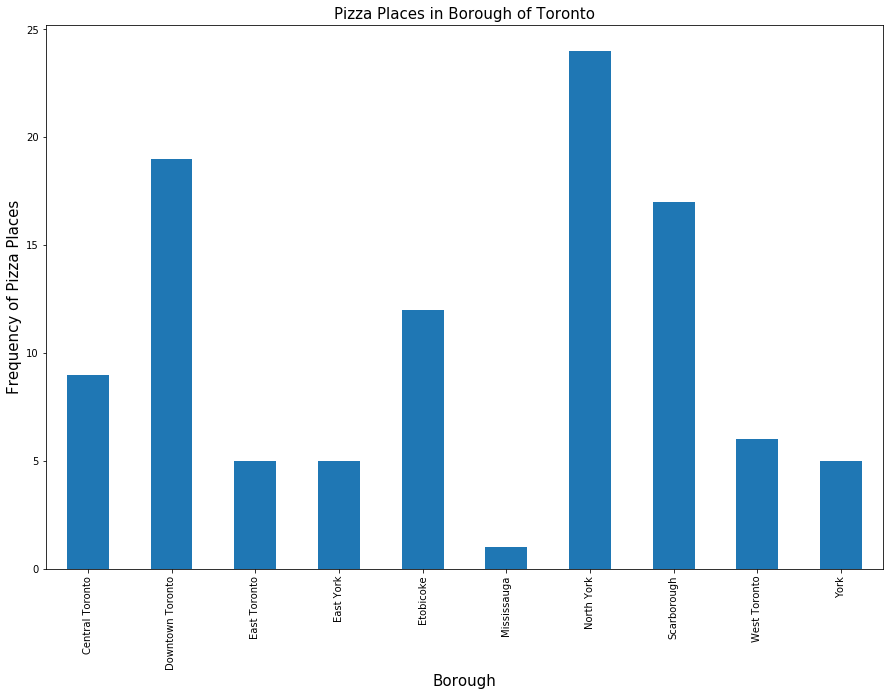

In [53]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,10))
plt.title('Pizza Places in Borough of Toronto', fontsize=15)
plt.xlabel("Borough", fontsize=15)
plt.ylabel ("Frequency of Pizza Places", fontsize=15)
toronto_PizzaPlace_merged.groupby('Borough')['Pizza Place'].count().plot(kind='bar')
plt.show()

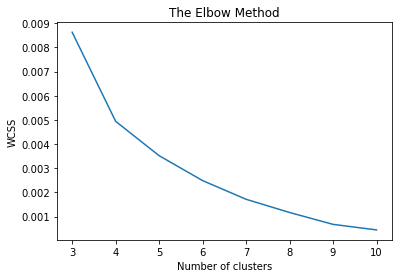

In [36]:
# Using the elbow method to find the optimal number of clusters
# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

toronto_PizzaPlace_Clustering = toronto_PizzaPlace.drop('Neighborhood', 1)


wcss = []

for i in range(3, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter= 50)
    kmeans.fit(toronto_PizzaPlace_Clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(3, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

In [37]:
# set number of clusters
kclusters = 6

toronto_PizzaPlace_Clustering = toronto_PizzaPlace.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_PizzaPlace_Clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 2, 0, 5, 2, 1, 5, 1, 2, 2, 2, 5, 5, 1, 5, 1, 1, 4, 1, 4, 2, 4,
       2, 4, 4, 5, 2, 4, 1, 1, 2, 1, 2, 0, 3, 1, 1, 4, 5, 5, 4, 1, 5, 0,
       2, 0, 1, 1, 1, 2, 4, 4, 2, 1, 2, 0, 1, 5, 3, 4, 1, 0, 2, 1, 1, 1,
       1, 2, 3, 4, 4, 4, 3, 1, 1, 4, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 5, 1,
       4, 3, 1, 4, 1, 2, 3, 2, 0, 2, 1], dtype=int32)

In [38]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_PizzaPlace_Clustering_merged = toronto_PizzaPlace.copy()
# add clustering labels
toronto_PizzaPlace_Clustering_merged["Cluster Labels"] = kmeans.labels_
toronto_PizzaPlace_Clustering_merged.head()

,Neighborhood,Pizza Place,Cluster Labels
0,Agincourt,0.016393,1
1,"Alderwood, Long Branch",0.042553,2
2,"Bathurst Manor, Wilson Heights, Downsview North",0.073171,0
3,Bayview Village,0.000000,5
4,"Bedford Park, Lawrence Manor East",0.027027,2


In [39]:
# Now let's merge the Toronto Geodata and the Toronto Pizza Places data per Neighborhood with Cluster labels
toronto_PizzaPlace_Clustering_merged2 = pd.merge(df_Toronto_Geodata, toronto_PizzaPlace_Clustering_merged[['Neighborhood','Pizza Place', 'Cluster Labels']], on='Neighborhood')

toronto_PizzaPlace_Clustering_merged2.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Pizza Place,Cluster Labels
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.055556,4
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.090909,3
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.093750,3
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.030303,2
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.000000,5


In [40]:
# Let's sort the results by Cluster Labels
print(toronto_PizzaPlace_Clustering_merged2.shape)
toronto_PizzaPlace_Clustering_merged2.sort_values(["Cluster Labels"], inplace=True)
toronto_PizzaPlace_Clustering_merged2

(103, 7)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,Pizza Place,Cluster Labels
79,M6L,North York,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,0.064516,0
36,M4C,East York,Woodbine Heights,43.695344,-79.318389,0.073529,0
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,0.073171,0
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0.073171,0
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,0.081081,0
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,0.076923,0
35,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0.076923,0
51,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.010000,1
50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0.010000,1
49,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,0.010000,1


In [41]:
import folium
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_PizzaPlace_Clustering_merged2['Latitude'], toronto_PizzaPlace_Clustering_merged2['Longitude'], toronto_PizzaPlace_Clustering_merged2['Neighborhood'], toronto_PizzaPlace_Clustering_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [42]:
# Cluster 0
toronto_PizzaPlace_Cluster0 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 0]
print(toronto_PizzaPlace_Cluster0.shape)
toronto_PizzaPlace_Cluster0

(7, 7)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,Pizza Place,Cluster Labels
79,M6L,North York,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,0.064516,0
36,M4C,East York,Woodbine Heights,43.695344,-79.318389,0.073529,0
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,0.073171,0
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0.073171,0
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,0.081081,0
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,0.076923,0
35,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0.076923,0


In [43]:
# Cluster 1
toronto_PizzaPlace_Cluster1 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 1]
print(toronto_PizzaPlace_Cluster1.shape)
toronto_PizzaPlace_Cluster1

(36, 7)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,Pizza Place,Cluster Labels
51,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.010000,1
50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0.010000,1
49,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,0.010000,1
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0.012500,1
46,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,0.020000,1
78,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,0.010000,1
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0.020000,1
39,M4H,East York,Thorncliffe Park,43.705369,-79.349372,0.010204,1
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0.020000,1
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0.015385,1


In [44]:
# Cluster 2
toronto_PizzaPlace_Cluster2 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 2]
print(toronto_PizzaPlace_Cluster2.shape)
toronto_PizzaPlace_Cluster2

(23, 7)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,Pizza Place,Cluster Labels
64,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307,0.030000,2
88,M8V,Etobicoke,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,0.025641,2
62,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,0.027027,2
92,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,0.026316,2
68,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,0.028986,2
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.030303,2
90,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0.030303,2
72,M6B,North York,Glencairn,43.709577,-79.445073,0.036364,2
74,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,0.041096,2
67,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,0.040000,2


In [45]:
# Cluster 3
toronto_PizzaPlace_Cluster3 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 3]
print(toronto_PizzaPlace_Cluster3.shape)
toronto_PizzaPlace_Cluster3

(6, 7)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,Pizza Place,Cluster Labels
99,M9P,Etobicoke,Westmount,43.696319,-79.532242,0.088235,3
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.093750,3
29,M3J,North York,"Northwood Park, York University",43.767980,-79.487262,0.088889,3
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.090909,3
24,M2R,North York,"Willowdale, Willowdale West",43.782736,-79.442259,0.114286,3
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,0.088235,3


In [46]:
# Cluster 4
toronto_PizzaPlace_Cluster4 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 4]
print(toronto_PizzaPlace_Cluster4.shape)
toronto_PizzaPlace_Cluster4

(20, 7)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,Pizza Place,Cluster Labels
94,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,0.045455,4
95,M9C,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201,0.046512,4
81,M6N,York,"Runnymede, The Junction North",43.673185,-79.487262,0.062500,4
91,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,0.052632,4
80,M6M,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,0.052632,4
84,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,0.053571,4
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.055556,4
15,M1W,Scarborough,"Steeles West, L'Amoreaux West",43.799525,-79.318389,0.051282,4
73,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,0.044944,4
47,M4S,Central Toronto,Davisville,43.704324,-79.388790,0.050000,4


In [47]:
# Cluster 5
toronto_PizzaPlace_Cluster5 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 5]
print(toronto_PizzaPlace_Cluster5.shape)
toronto_PizzaPlace_Cluster5

(11, 7)


,Postalcode,Borough,Neighborhood,Latitude,Longitude,Pizza Place,Cluster Labels
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,5
97,M9M,North York,"Humberlea, Emery",43.724766,-79.532242,0.0,5
96,M9L,North York,Humber Summit,43.756303,-79.565963,0.0,5
75,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0.0,5
93,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,0.0,5
76,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,0.0,5
16,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,0.0,5
19,M2K,North York,Bayview Village,43.786947,-79.385975,0.0,5
86,M7R,Mississauga,Canada Post Gateway Processing Centre,43.636966,-79.615819,0.0,5
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0.0,5
